# DeepSEM

In [3]:
! lamin load jkobject/scprint

→ connected lamindb: jkobject/scprint


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GNInfer

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3
from grnndata import utils as grnutils
from anndata.utils import make_index_unique
import pandas as pd
import numpy as np

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
from grnndata import GRNAnnData

import sys
sys.path.append("../tools/DeepSEM")

from src.DeepSEM_cell_type_test_specific_GRN_model import celltype_GRN_model as test_celltype_GRN_model

class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def run_deepsem(adata):
    opt = DotDict({
        'beta': 0.01,
        'alpha': 1,
        'K1': 1,
        'K2': 2,
        'K': 1,
        'net_file': "",
        'n_epochs': 50,
        'n_hidden': 128,
        'gamma': 0.95,
        'lr': 1e-4,
        'lr_step_size': 0.99,
        'batch_size': 64,
        'data_file': "/tmp/deepsem.h5ad",
        'save_name': "/tmp/deepsem/",
        'task': "celltype_GRN"
    })
    adata.X = adata.X.toarray()
    adata.write("/tmp/deepsem.h5ad")
    model = test_celltype_GRN_model(opt)
    net = model.train_model()
    grn = GRNAnnData(adata.copy(), grn=net)
    del net
    return grn

In [3]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()

650

In [4]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [5]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
NUM_GENES = 5000
NUM_CELLS = 1024
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 1 genes.
startin QC
Seeing 10066 outliers (94.15% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [20]:
import regdiffusion as rd

rd_trainer = rd.RegDiffusionTrainer(subadata.X.toarray())
rd_trainer.train()
grn = rd_trainer.get_adj()


Training loss: 0.328, Change on Adj: -0.000: 100%|██████████| 1000/1000 [00:52<00:00, 18.93it/s]


In [21]:
grn = GRNAnnData(subadata.copy(), grn=grn)

precision:  0.021462814026651896 
recall:  0.6529636377597677 
random precision: 0.020718126571001305


 98%|█████████▊| 126/128 [00:09<00:00, 12.85it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:10<00:00, 12.74it/s]


Average Precision (AP):  0.030823114022404265
Area Under Precision-Recall Curve (AUPRC):  0.029202769157061895
EPR: 2.8361441109211505


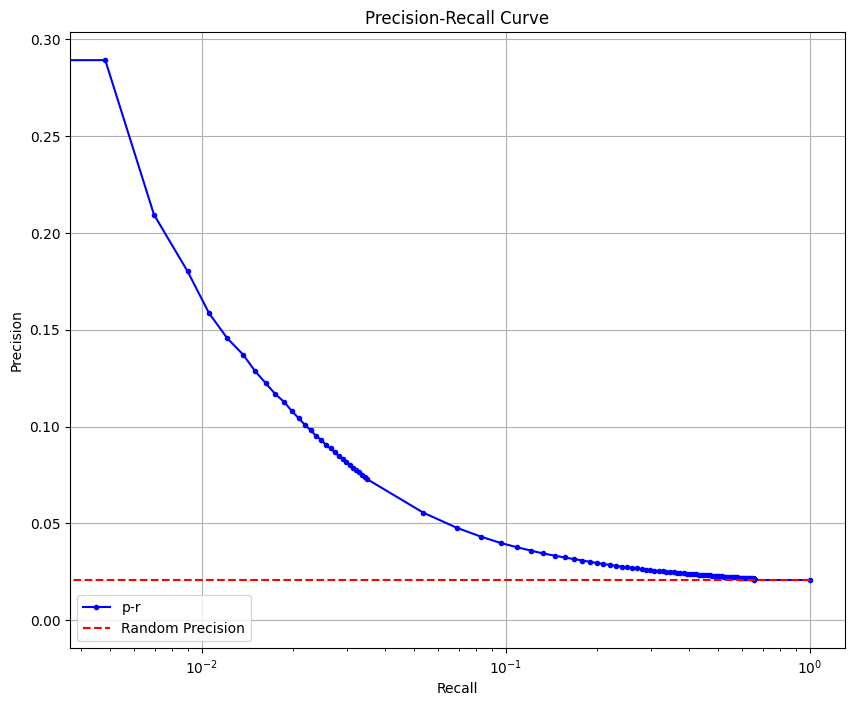

{'precision': 0.021462814026651896,
 'recall': 0.6529636377597677,
 'rand_precision': 0.020718126571001305,
 'auprc': 0.029202769157061895,
 'ap': 0.030823114022404265,
 'epr': 2.8361441109211505}

: 

In [23]:
grn.var.index = subadata.var.index
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

precision:  0.02494372922005217 
recall:  0.76797316748351 
random precision: 0.023550483591021854


 99%|█████████▉| 127/128 [00:35<00:00,  3.60it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:35<00:00,  3.60it/s]


Average Precision (AP):  0.05089393545819771
Area Under Precision-Recall Curve (AUPRC):  0.0485535239561503
EPR: 5.050201260455798


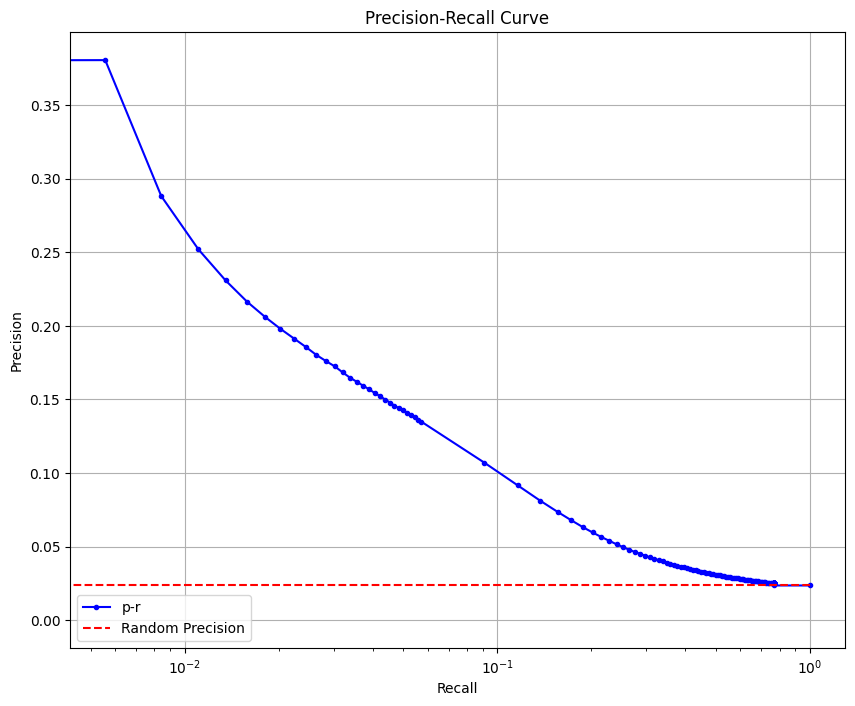

NameError: name 'metrics' is not defined

In [17]:
grn.var.index = adata.var.index
metrics['deepsem_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:NUM_CELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
del subadata.varp['GRN']
metrics = {}

In [7]:
grn = run_deepsem(subadata)

save dir exist
epoch: 1 0.3394379420205951 mse_loss: 0.28156959917396307 kl_loss: 0.057368417154066265 sparse_loss: 0.0004999326974939322
epoch: 2 0.3433423787355423 mse_loss: 0.28040110878646374 kl_loss: 0.06239362503401935 sparse_loss: 0.0005476522819662932
epoch: 4 0.2549485294148326 mse_loss: 0.20182013977319002 kl_loss: 0.05256537429522723 sparse_loss: 0.0005630164996546227
epoch: 5 0.21680025942623615 mse_loss: 0.16258406732231379 kl_loss: 0.05364080925937742 sparse_loss: 0.0005753757504862733
epoch: 7 0.2729117264971137 mse_loss: 0.21916299406439066 kl_loss: 0.05316401633899659 sparse_loss: 0.0005847107531735674
epoch: 8 0.1923281503841281 mse_loss: 0.13816918758675456 kl_loss: 0.053565213456749916 sparse_loss: 0.0005937457026448101
epoch: 10 0.16011619800701737 mse_loss: 0.10847207717597485 kl_loss: 0.05104723433032632 sparse_loss: 0.000596883190155495
epoch: 11 0.19651614222675562 mse_loss: 0.14470768487080932 kl_loss: 0.05120842542964965 sparse_loss: 0.0006000259090797044
epo

precision:  0.020546889236634377 
recall:  0.9917349025849371 
random precision: 0.020718126571001305


 98%|█████████▊| 126/128 [00:05<00:00, 22.99it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:05<00:00, 23.23it/s]


Average Precision (AP):  0.0192414080409506
Area Under Precision-Recall Curve (AUPRC):  0.01923987210591184
EPR: 0.8512560757458091


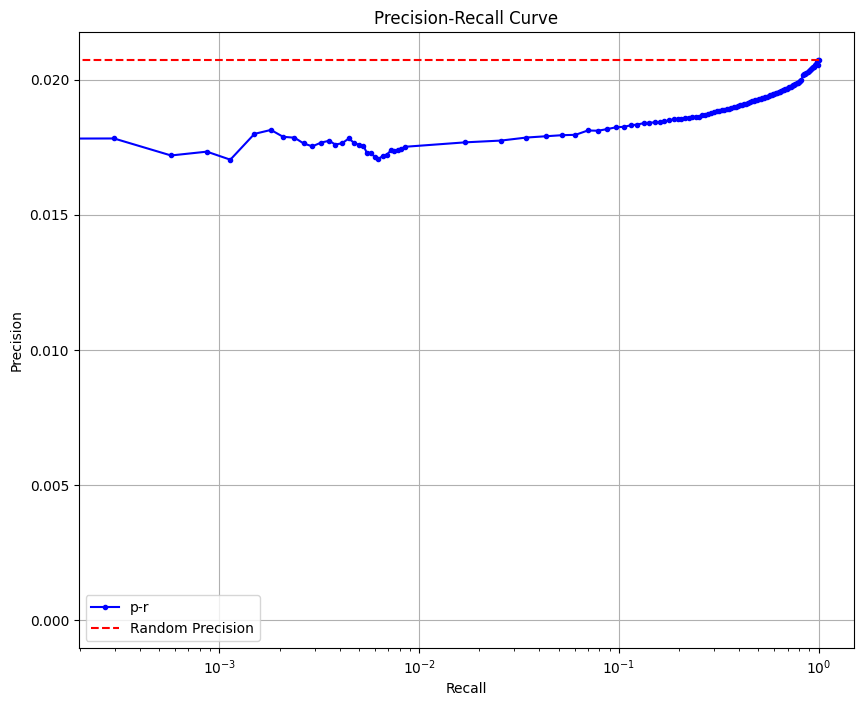

In [8]:
grn.var.index = subadata.var.index
metrics['deepsem_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


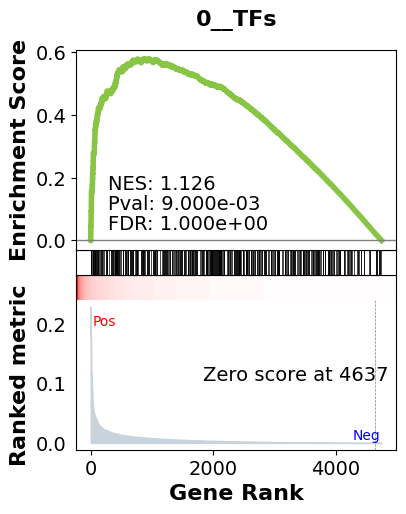

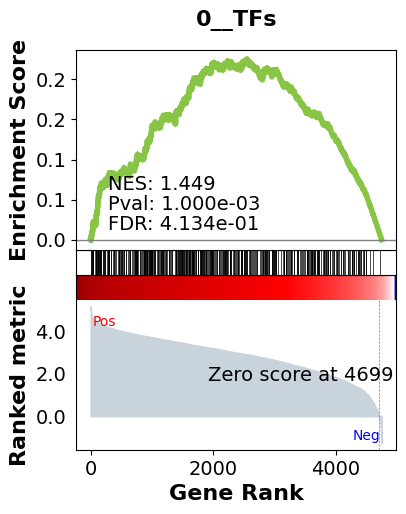

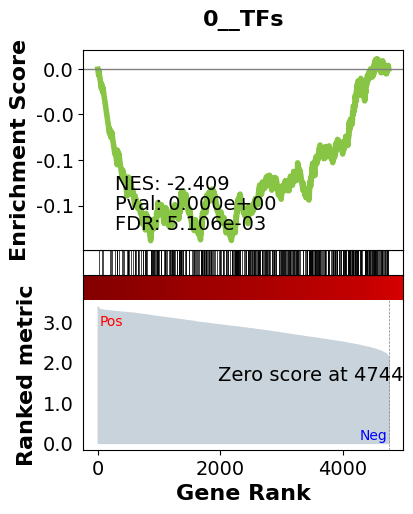

_________________________________________
TF specific enrichment
found some significant results for  3.5714285714285716 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.00163245054093197 
recall:  0.99988483906259 
random precision: 0.0016326385571186594


 99%|█████████▉| 127/128 [00:07<00:00, 15.82it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:07<00:00, 16.40it/s]


Average Precision (AP):  0.0015631063294741221
Area Under Precision-Recall Curve (AUPRC):  0.0015624020154527698
EPR: 0.8106709149659675


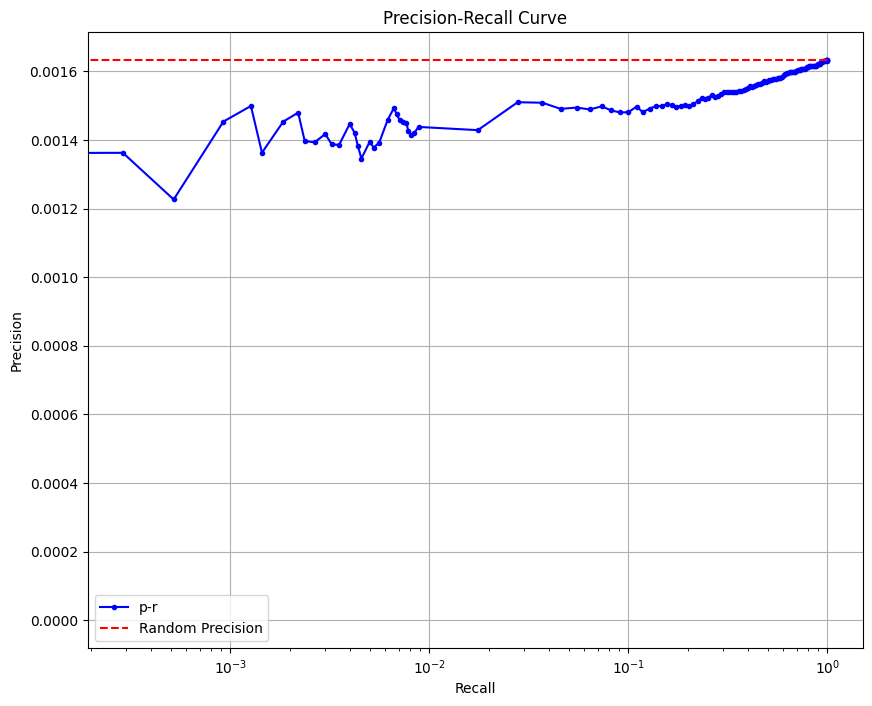

In [10]:
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
metrics['deepsem_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

# on TF only

In [9]:
# Set non-TF connections to 0
non_tf_mask = ~grn.var['isTF'].values
# Set connections to non-TFs to 0
grn.varp['GRN'][non_tf_mask, :] = 0

In [10]:
non_tf_mask = ~adata.var['isTF'].values
adata.varp['GRN'][non_tf_mask, :] = 0

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


precision:  0.015117780354131534 
recall:  0.9900166389351082 
random precision: 0.015270228559383281


 98%|█████████▊| 125/128 [00:00<00:00, 411.72it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 404.70it/s]


Average Precision (AP):  0.013868343996719004
Area Under Precision-Recall Curve (AUPRC):  0.013859467831743306
EPR: 0.7899591066189448


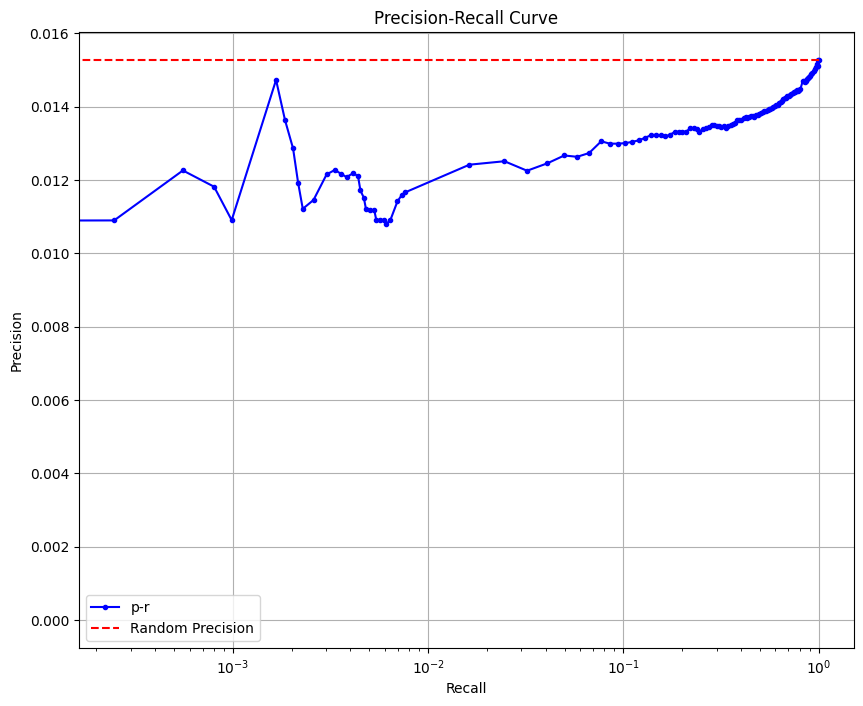

In [11]:
grn.var.index = grn.var.ensembl_id
metrics['deepsem_tf_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [12]:
metrics

{'deepsem_perturb': {'precision': 0.020546889236634377,
  'recall': 0.9917349025849371,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.01923987210591184,
  'ap': 0.0192414080409506,
  'epr': 0.8512560757458091},
 'deepsem_tf_perturb': {'precision': 0.015117780354131534,
  'recall': 0.9900166389351082,
  'rand_precision': 0.015270228559383281,
  'auprc': 0.013859467831743306,
  'ap': 0.013868343996719004,
  'epr': 0.7899591066189448}}

base enrichment
Top central genes: []


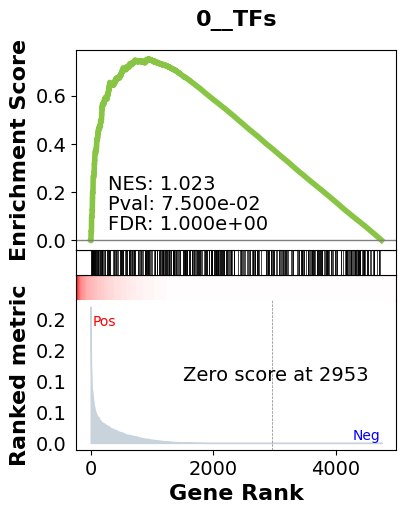

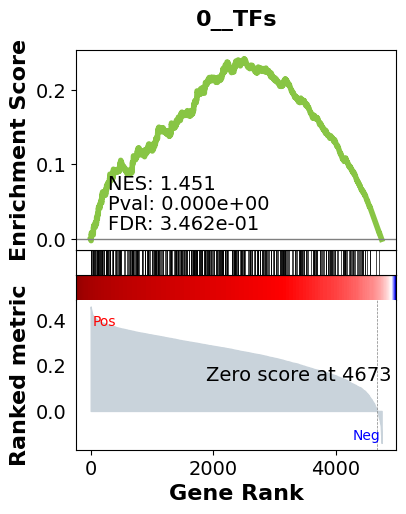

_________________________________________
TF specific enrichment


found some significant results for  1.7857142857142858 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.008116119799652459 
recall:  0.5714861518972765 
random precision: 0.0016326385571186594


 98%|█████████▊| 126/128 [00:07<00:00, 15.28it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:08<00:00, 15.77it/s]


Average Precision (AP):  0.005236328010814163
Area Under Precision-Recall Curve (AUPRC):  0.004988737690141536
EPR: 4.421966532211448


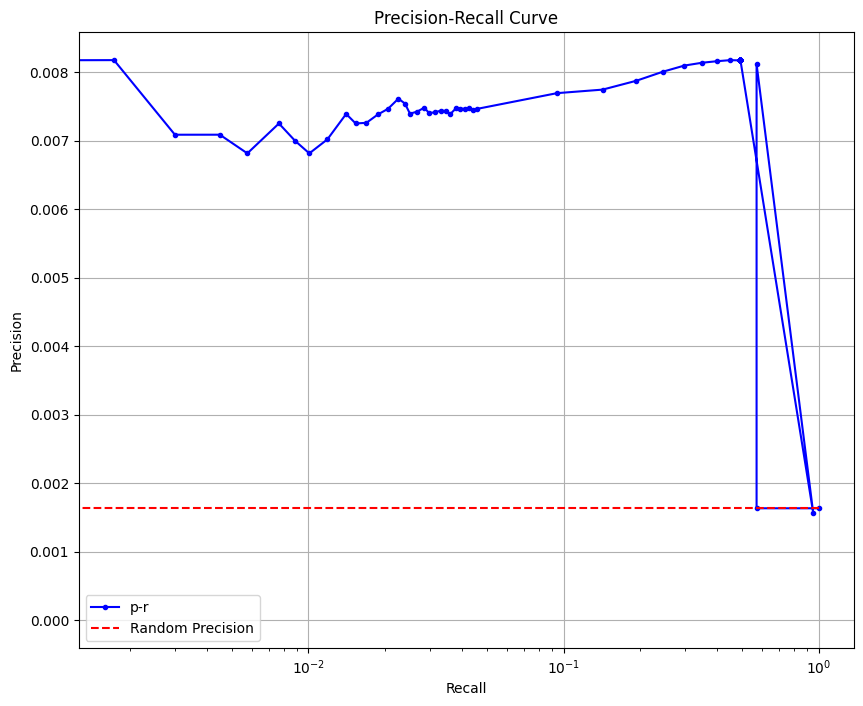

In [14]:
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
metrics['deepsem_tf_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [15]:
metrics

{'deepsem_perturb': {'precision': 0.020546889236634377,
  'recall': 0.9917349025849371,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.01907024542443785,
  'ap': 0.019075052125128732,
  'epr': 0.8262901650410917},
 'deepsem_perturb_base': {'TF_enr': True,
  'significant_enriched_TFtargets': 3.5714285714285716,
  'precision': 0.00163245054093197,
  'recall': 0.99988483906259,
  'rand_precision': 0.0016326385571186594,
  'auprc': 0.0015624020154527698,
  'ap': 0.0015631063294741221,
  'epr': 0.8106709149659675},
 'deepsem_tf_perturb': {'precision': 0.015117780354131534,
  'recall': 0.9900166389351082,
  'rand_precision': 0.015270228559383281,
  'auprc': 0.013729146887508028,
  'ap': 0.01375745678319313,
  'epr': 0.7448191921050634},
 'deepsem_tf_perturb_base': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Plasma B cells',
   'celltype.gmt__Memory B cells',
   'celltype.gmt__Naive B cells'],
  'significant_enriched_TFtargets': 1.7857142857142858,
  'precision': 

In [16]:
import pandas as pd

In [17]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,perturb,0.826290,0.019070,0.020718,False
1,perturb,0.744819,0.013729,0.015270,True


In [18]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,perturb,0.810671,0.001562,0.001633,3.571429,True,False
1,perturb,4.421967,0.004989,0.001633,1.785714,False,True
